## 神经网络实现鸢尾花分类

利用神经网络实现鸢尾花分类，大致需要三个步骤
 1. 准备数据
 2. 搭建网络
 3. 参数优化

### 1. 准备数据

In [1]:
import tensorflow as tf
import numpy as np

#### 1.1 数据集读入

从 sklearn 的 datasets 中读入鸢尾花（iris）数据集，并获取数据集所有输入特征和标签

In [2]:
from sklearn import datasets

In [3]:
iris = datasets.load_iris()
x_data = iris.data
y_data = iris.target

#### 1.2 数据集乱序

通过设定相同的随机种子，使得打乱顺序后的输入特征和标签仍能一一对应

In [4]:
np.random.seed(666)
np.random.shuffle(x_data)
np.random.seed(666) # 每次乱序前都需要设定随机种子
np.random.shuffle(y_data)
tf.random.set_seed(666)

#### 1.3 生成训练集和测试集

数据个数为 150，[0,120] 为训练集，[121, 150] 为测试集，即训练集和测试集没有交集。

In [5]:
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

# 转换数据类型，否则后面矩阵相乘时会因为数据类型不一致而报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

#### 1.4 配成（输入特征，标签）对，每次读入一小撮（batch）

In [6]:
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

### 2. 搭建网络
 
该神经网络只有输入层（4个神经元）和输出层（3个神经元），没有隐藏层。即该网络是具有 4 个输入特征的 3 分类问题。

随机初始化权重（w1）和偏置（b1）,符合均值为 0， 标准差为 0.1 的分布

w1 为 4 行 3 列的张量，即 [输入节点个数，输出节点个数]

b1 的值需要与输出节点个数一致，即 [3]

In [7]:
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1))

### 3. 参数优化

定义超参数

In [8]:
lr = 0.1                 # 学习率为 0.1
epoch = 500              # 迭代 500 次
loss_all = 0             # 每轮 4 个 step, loss_all 记录 4 个 step 生成的 4 个 loss 的和
train_loss_results = []  # 记录每轮的损失函数 loss，用于后续绘制 loss 曲线
test_acc = []            # 记录每轮的准确率 acc，用于后续绘制 acc 曲线

嵌套循环迭代，在 with 结构中求得损失函数 loss 对每个可训练参数的偏导数，并更新这些可训练参数，最后显示当前的 loss

In [9]:
for i in range(epoch):
    for step, (x_train, y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:
            # y = XW + b
            y = tf.matmul(x_train, w1) + b1
            # 将计算结果传入激活函数 softmax，使输出符合概率分布
            y = tf.nn.softmax(y)
            # 将标签转换为 one-hot 编码，方便计算 loss 和
            y_ = tf.one_hot(y_train, depth=3)
            # 损失函数定义为均方误差 MSE
            loss = tf.reduce_mean(tf.square(y_ - y))
            # 将每个 step 计算出的 loss 累加，用于后续求 loss 平均值
            loss_all += loss.numpy()
        # 计算损失函数 loss 中各个参数的梯度 
        grads = tape.gradient(loss, [w1, b1])
        
        # 梯度更新
        # w1 = w1 - lr * w1_grads
        w1.assign_sub(lr * grads[0])
        # b1 = b1 - lr * b1_grads
        b1.assign_sub(lr * grads[1])
    
    # 每次迭代都打印损失函数 loss 的信息
    print("Epoch {}, loss: {}".format(i, loss_all / 4))
    # 记录每轮的平均损失
    train_loss_results.append(loss_all / 4)
    # loss_all 清零，方便下次迭代计算
    loss_all = 0
    
    
    # 测试训练效果，计算当前参数前向传播后的准确率
    # 初始化预测正确样本个数和样本总数
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        # 获取预测结果
        pred = tf.argmax(y, axis=1)
        # 保持运算数据类型一致
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 将预测结果和正确结果进行比较
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 统计预测正确的总和
        correct = tf.reduce_sum(correct)
        total_correct += int(correct)
        total_number += x_test.shape[0]
    acc = total_correct / total_number
    test_acc.append(acc)
    print("accuracy:", acc)
    print('-----------------------------------')

Epoch 0, loss: 0.1989009529352188
accuracy: 0.5
-----------------------------------
Epoch 1, loss: 0.18588490411639214
accuracy: 0.6666666666666666
-----------------------------------
Epoch 2, loss: 0.17692162469029427
accuracy: 0.6666666666666666
-----------------------------------
Epoch 3, loss: 0.16934260353446007
accuracy: 0.6666666666666666
-----------------------------------
Epoch 4, loss: 0.16269876062870026
accuracy: 0.6666666666666666
-----------------------------------
Epoch 5, loss: 0.15691311284899712
accuracy: 0.6666666666666666
-----------------------------------
Epoch 6, loss: 0.15188119933009148
accuracy: 0.6666666666666666
-----------------------------------
Epoch 7, loss: 0.14749163016676903
accuracy: 0.6666666666666666
-----------------------------------
Epoch 8, loss: 0.14364120736718178
accuracy: 0.6666666666666666
-----------------------------------
Epoch 9, loss: 0.14024024456739426
accuracy: 0.6666666666666666
-----------------------------------
Epoch 10, loss: 

accuracy: 0.8333333333333334
-----------------------------------
Epoch 85, loss: 0.074534029699862
accuracy: 0.8333333333333334
-----------------------------------
Epoch 86, loss: 0.07413831166923046
accuracy: 0.8333333333333334
-----------------------------------
Epoch 87, loss: 0.07374719437211752
accuracy: 0.8333333333333334
-----------------------------------
Epoch 88, loss: 0.07336061168462038
accuracy: 0.8333333333333334
-----------------------------------
Epoch 89, loss: 0.07297847792506218
accuracy: 0.8333333333333334
-----------------------------------
Epoch 90, loss: 0.07260074652731419
accuracy: 0.8333333333333334
-----------------------------------
Epoch 91, loss: 0.07222733180969954
accuracy: 0.8333333333333334
-----------------------------------
Epoch 92, loss: 0.07185818254947662
accuracy: 0.8333333333333334
-----------------------------------
Epoch 93, loss: 0.07149321585893631
accuracy: 0.8333333333333334
-----------------------------------
Epoch 94, loss: 0.0711323814

Epoch 180, loss: 0.050657257437705994
accuracy: 0.9333333333333333
-----------------------------------
Epoch 181, loss: 0.05050232447683811
accuracy: 0.9333333333333333
-----------------------------------
Epoch 182, loss: 0.050348675809800625
accuracy: 0.9333333333333333
-----------------------------------
Epoch 183, loss: 0.05019628442823887
accuracy: 0.9333333333333333
-----------------------------------
Epoch 184, loss: 0.050045148469507694
accuracy: 0.9333333333333333
-----------------------------------
Epoch 185, loss: 0.049895250238478184
accuracy: 0.9333333333333333
-----------------------------------
Epoch 186, loss: 0.04974656458944082
accuracy: 0.9333333333333333
-----------------------------------
Epoch 187, loss: 0.04959908965975046
accuracy: 0.9333333333333333
-----------------------------------
Epoch 188, loss: 0.04945279937237501
accuracy: 0.9333333333333333
-----------------------------------
Epoch 189, loss: 0.049307700246572495
accuracy: 0.9333333333333333
-----------

accuracy: 0.9666666666666667
-----------------------------------
Epoch 276, loss: 0.04003222472965717
accuracy: 0.9666666666666667
-----------------------------------
Epoch 277, loss: 0.03995406161993742
accuracy: 0.9666666666666667
-----------------------------------
Epoch 278, loss: 0.03987637674435973
accuracy: 0.9666666666666667
-----------------------------------
Epoch 279, loss: 0.039799153339117765
accuracy: 0.9666666666666667
-----------------------------------
Epoch 280, loss: 0.039722416549921036
accuracy: 0.9666666666666667
-----------------------------------
Epoch 281, loss: 0.03964612819254398
accuracy: 0.9666666666666667
-----------------------------------
Epoch 282, loss: 0.03957030735909939
accuracy: 0.9666666666666667
-----------------------------------
Epoch 283, loss: 0.03949494240805507
accuracy: 0.9666666666666667
-----------------------------------
Epoch 284, loss: 0.039420027285814285
accuracy: 0.9666666666666667
-----------------------------------
Epoch 285, los

Epoch 367, loss: 0.03445687144994736
accuracy: 0.9666666666666667
-----------------------------------
Epoch 368, loss: 0.034409127198159695
accuracy: 0.9666666666666667
-----------------------------------
Epoch 369, loss: 0.03436160972341895
accuracy: 0.9666666666666667
-----------------------------------
Epoch 370, loss: 0.0343143199570477
accuracy: 0.9666666666666667
-----------------------------------
Epoch 371, loss: 0.03426723973825574
accuracy: 0.9666666666666667
-----------------------------------
Epoch 372, loss: 0.03422040352597833
accuracy: 0.9666666666666667
-----------------------------------
Epoch 373, loss: 0.03417377592995763
accuracy: 0.9666666666666667
-----------------------------------
Epoch 374, loss: 0.03412737837061286
accuracy: 0.9666666666666667
-----------------------------------
Epoch 375, loss: 0.03408118849620223
accuracy: 0.9666666666666667
-----------------------------------
Epoch 376, loss: 0.03403522493317723
accuracy: 0.9666666666666667
----------------

accuracy: 0.9666666666666667
-----------------------------------
Epoch 459, loss: 0.03084978787228465
accuracy: 0.9666666666666667
-----------------------------------
Epoch 460, loss: 0.030817718245089054
accuracy: 0.9666666666666667
-----------------------------------
Epoch 461, loss: 0.03078577248379588
accuracy: 0.9666666666666667
-----------------------------------
Epoch 462, loss: 0.030753951519727707
accuracy: 0.9666666666666667
-----------------------------------
Epoch 463, loss: 0.03072225395590067
accuracy: 0.9666666666666667
-----------------------------------
Epoch 464, loss: 0.030690676532685757
accuracy: 0.9666666666666667
-----------------------------------
Epoch 465, loss: 0.03065922111272812
accuracy: 0.9666666666666667
-----------------------------------
Epoch 466, loss: 0.03062789188697934
accuracy: 0.9666666666666667
-----------------------------------
Epoch 467, loss: 0.030596685130149126
accuracy: 0.9666666666666667
-----------------------------------
Epoch 468, lo

### 绘制损失函数 loss 和准确率 acc 的变化曲线

In [10]:
import matplotlib.pyplot as plt

绘制损失函数 loss 的曲线

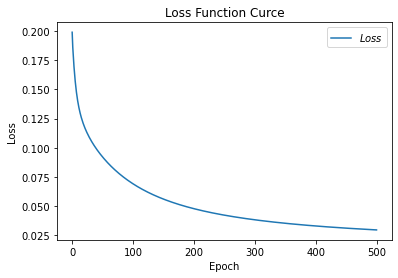

In [11]:
plt.title("Loss Function Curce")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_loss_results, label="$Loss$")
plt.legend()
plt.show()

绘制准确率 acc 的曲线

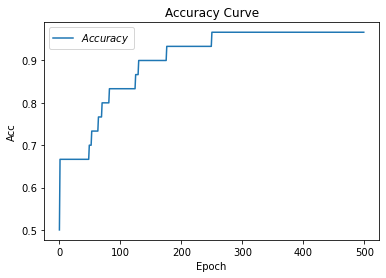

In [12]:
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.plot(test_acc, label="$Accuracy$")
plt.legend()
plt.show()